In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from itertools import combinations

In this question I used Resnet model.

# Part 1

In this part first of all I load the CIFAR10 dataset and then filter the dataset and choose the Airplane and Automobile calsses.

Then I loaded the model and pretrained weights for backbone and finally initialized the fully connected layer with random weights (Xavier weights).

I used CE as loss function and SGD as optimizer with lr=0.001 and momentum=0.9 . The model is trained for 10 epochs. You can see the model performance and plots in the output of following cell.

100%|██████████| 170498071/170498071 [00:03<00:00, 46212992.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can als

Epoch 1/10, Loss: 0.10678365307610137, Accuracy: 0.9566
Epoch 2/10, Loss: 0.03285224029880624, Accuracy: 0.9886
Epoch 3/10, Loss: 0.011832262174151585, Accuracy: 0.997
Epoch 4/10, Loss: 0.008765518338267561, Accuracy: 0.998
Epoch 5/10, Loss: 0.006154461256399942, Accuracy: 0.9978
Epoch 6/10, Loss: 0.00531436271652777, Accuracy: 0.9983
Epoch 7/10, Loss: 0.0038985436832951735, Accuracy: 0.9986
Epoch 8/10, Loss: 0.004567427819846564, Accuracy: 0.9984
Epoch 9/10, Loss: 0.0032401318263167015, Accuracy: 0.999
Epoch 10/10, Loss: 0.0027645957492228325, Accuracy: 0.9993


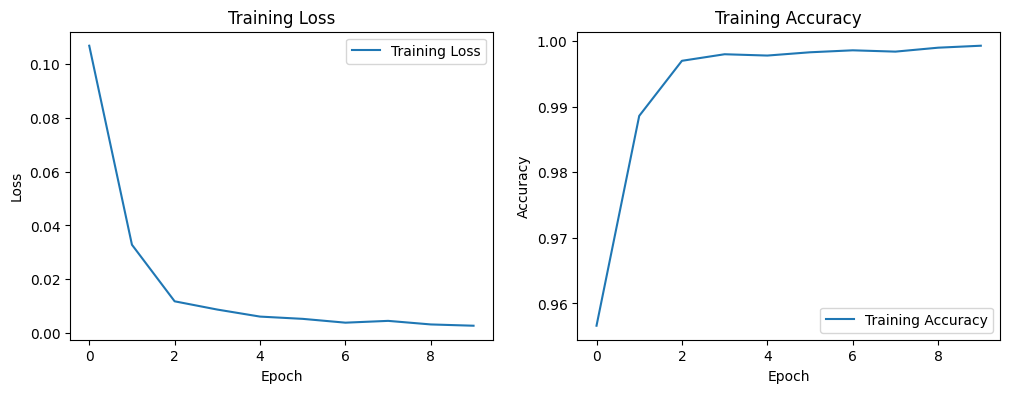

Accuracy on the test set: 99.15%


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load Cifar-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter the dataset for Automobile (class 1) and Airplane (class 0)
classes_of_interest = [0, 1]
train_indices = [i for i, label in enumerate(train_dataset.targets) if label in classes_of_interest]
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)

# Similarly, filter the test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_indices = [i for i, label in enumerate(test_dataset.targets) if label in classes_of_interest]
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load pre-trained ResNet model
resnet = models.resnet18(pretrained=True)

# Keep the weights of the existing layers and only replace the fully connected layer
num_classes = len(classes_of_interest)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Initialize the fully connected layer with random weights
nn.init.xavier_uniform_(resnet.fc.weight)
nn.init.zeros_(resnet.fc.bias)

# Move the model to the device
resnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 10
losses = []
accuracies = []

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

# Plotting
plt.figure(figsize=(12, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluation
resnet.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {100 * accuracy:.2f}%")

As you see the model  top accuracy on training set is 99.93% and on testset is 99.15%.

# Part2

Triplet loss is commonly used in face recognition and other metric learning tasks, where the goal is to learn embeddings such that the distance between similar samples (anchor-positive pair) is minimized, while the distance between dissimilar samples (anchor-negative pair) is maximized by at least a specified margin.

I implemented two functions 'pairwise_distance_torch print' and 'tripletLoss' and a class 'TripletLoss'. You can see explanation of them in following cells.

pairwise_distance_torch function :Computes the pairwise distance matrix with numerical stability.

- output[i, j] = || feature[i, :] - feature[j, :] ||_2
- Args:
embeddings: 2-D Tensor of size [number of data, feature dimension].
- Returns:
pairwise_distances: 2-D Tensor of size [number of data, number of data].
    

In [3]:
def pairwise_distance_torch(embeddings, device):

    # pairwise distance matrix with precise embeddings
    precise_embeddings = embeddings.to(dtype=torch.float32)

    c1 = torch.pow(precise_embeddings, 2).sum(axis=-1)
    c2 = torch.pow(precise_embeddings.transpose(0, 1), 2).sum(axis=0)
    c3 = precise_embeddings @ precise_embeddings.transpose(0, 1)

    c1 = c1.reshape((c1.shape[0], 1))
    c2 = c2.reshape((1, c2.shape[0]))
    c12 = c1 + c2
    pairwise_distances_squared = c12 - 2.0 * c3

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = torch.max(pairwise_distances_squared, torch.tensor([0.]).to(device))

    # Get the mask where the zero distances are at.
    error_mask = pairwise_distances_squared.clone()
    error_mask[error_mask > 0.0] = 1.
    error_mask[error_mask <= 0.0] = 0.

    pairwise_distances = torch.mul(pairwise_distances_squared, error_mask)

    # Explicitly set diagonals to zero.
    mask_offdiagonals = torch.ones((pairwise_distances.shape[0], pairwise_distances.shape[1])) - torch.diag(torch.ones(pairwise_distances.shape[0]))
    pairwise_distances = torch.mul(pairwise_distances.to(device), mask_offdiagonals.to(device))
    return pairwise_distances


tripletLoss function:

Computes the triplet loss_functions with semi-hard negative mining.
The loss_functions encourages the positive distances (between a pair of embeddings with the same labels) to be smaller than the minimum negative distance among which are at least greater than the positive distance plus the margin constant (called semi-hard negative) in the mini-batch.
If no such negative exists, uses the largest negative distance instead.

In [8]:
def tripletLoss(y_true, y_pred, device, margin=1.0):

    labels, embeddings = y_true, y_pred

    # Reshape label tensor to [batch_size, 1].
    lshape = labels.shape
    labels = torch.reshape(labels, [lshape[0], 1])

    pdist_matrix =  pairwise_distance_torch(embeddings, device)

    # Build pairwise binary adjacency matrix.
    adjacency = torch.eq(labels, labels.transpose(0, 1))
    # Invert so we can select negatives only.
    adjacency_not = adjacency.logical_not()

    batch_size = labels.shape[0]

    # Compute the mask.
    pdist_matrix_tile = pdist_matrix.repeat(batch_size, 1)
    adjacency_not_tile = adjacency_not.repeat(batch_size, 1)

    transpose_reshape = pdist_matrix.transpose(0, 1).reshape(-1, 1)
    greater = pdist_matrix_tile > transpose_reshape

    mask = adjacency_not_tile & greater

    # final mask
    mask_step = mask.to(dtype=torch.float32)
    mask_step = mask_step.sum(axis=1)
    mask_step = mask_step > 0.0
    mask_final = mask_step.reshape(batch_size, batch_size)
    mask_final = mask_final.transpose(0, 1)

    adjacency_not = adjacency_not.to(dtype=torch.float32)
    mask = mask.to(dtype=torch.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    axis_maximums = torch.max(pdist_matrix_tile, dim=1, keepdim=True)
    masked_minimums = torch.min(torch.mul(pdist_matrix_tile - axis_maximums[0], mask), dim=1, keepdim=True)[0] + axis_maximums[0]
    negatives_outside = masked_minimums.reshape([batch_size, batch_size])
    negatives_outside = negatives_outside.transpose(0, 1)

    # negatives_inside: largest D_an.
    axis_minimums = torch.min(pdist_matrix, dim=1, keepdim=True)
    masked_maximums = torch.max(torch.mul(pdist_matrix - axis_minimums[0], adjacency_not), dim=1, keepdim=True)[0] + axis_minimums[0]
    negatives_inside = masked_maximums.repeat(1, batch_size)

    semi_hard_negatives = torch.where(mask_final, negatives_outside, negatives_inside)

    loss_mat = margin + pdist_matrix - semi_hard_negatives

    mask_positives = adjacency.to(dtype=torch.float32) - torch.diag(torch.ones(batch_size)).to(device)
    num_positives = mask_positives.sum()

    triplet_loss = (torch.max(torch.mul(loss_mat, mask_positives), torch.tensor([0.]).to(device))).sum() / num_positives
    triplet_loss = triplet_loss.to(dtype=embeddings.dtype)
    return triplet_loss

In [9]:
class TripletLoss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, input, target, **kwargs):
        return tripletLoss(target, input, self.device)

After implementing the triplet loss function, now in this part I freezed the FC layer and trained the feature extractor with triplet loss.
The model is trained with 10 epochs and SGD.
You can see the loss values in the following plot.

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can als

Epoch 1/10, Triplet Loss: 0.9202160907689089
Epoch 2/10, Triplet Loss: 0.13488338876033693
Epoch 3/10, Triplet Loss: 0.04473406104208928
Epoch 4/10, Triplet Loss: 0.02190390213051844
Epoch 5/10, Triplet Loss: 0.0066505808823689155
Epoch 6/10, Triplet Loss: 0.003385292686276827
Epoch 7/10, Triplet Loss: 0.005711220184815475
Epoch 8/10, Triplet Loss: 0.003364363932702579
Epoch 9/10, Triplet Loss: 0.000814590521752626
Epoch 10/10, Triplet Loss: 0.0005911717348201676


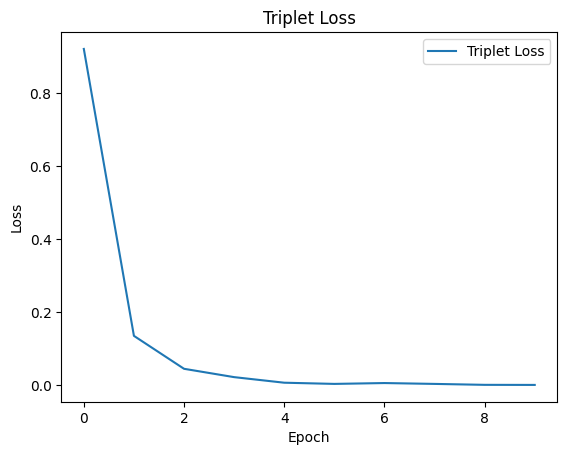

In [10]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load Cifar-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter the dataset for Automobile (class 1) and Airplane (class 0)
classes_of_interest = [0, 1]
train_indices = [i for i, label in enumerate(train_dataset.targets) if label in classes_of_interest]
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)

# Similarly, filter the test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_indices = [i for i, label in enumerate(test_dataset.targets) if label in classes_of_interest]
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load pre-trained ResNet model
resnet = models.resnet18(pretrained=True)

# save fc pretrained weights
fc_pretrained_biases = torch.tensor(resnet.fc.bias[:2])
fc_pretrained_weights = torch.tensor(resnet.fc.weight[:2,:])

# Keep the weights of the existing layers and only replace the fully connected layer
num_classes = len(classes_of_interest)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# load pretrained weights
resnet.fc.bias.data = fc_pretrained_biases
resnet.fc.weight.data = fc_pretrained_weights

# Freeze the pretrained weights of the fully connected layer
for param in resnet.fc.parameters():
    param.requires_grad = False

# Move the model to the device
resnet.to(device)

class TripletLoss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, input, target, **kwargs):
        return tripletLoss(target, input, self.device)

triplet_criterion = TripletLoss(device)

# Define optimizer
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Training loop with triplet loss
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)

        loss = triplet_criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Triplet Loss: {epoch_loss}")

    losses.append(epoch_loss)

# Plotting
plt.plot(losses, label='Triplet Loss')
plt.title('Triplet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now in this part I freezed the feature extractor and trained the FC layer with CE loss and pretrained weights. The model is trained with 10 epochs and SGD optimizer (lr=0.001, momentum=0.9).

The model performance on trainning and test set is available in following cell.

Epoch 1/10, Loss: 0.18140417296653644, Accuracy: 0.9431
Epoch 2/10, Loss: 0.023418039585591646, Accuracy: 0.9945
Epoch 3/10, Loss: 0.01669664464529437, Accuracy: 0.9967
Epoch 4/10, Loss: 0.014277395222316714, Accuracy: 0.9965
Epoch 5/10, Loss: 0.010818023421874526, Accuracy: 0.9976
Epoch 6/10, Loss: 0.012289652419008743, Accuracy: 0.9967
Epoch 7/10, Loss: 0.010798378226688703, Accuracy: 0.9973
Epoch 8/10, Loss: 0.012659060767853258, Accuracy: 0.9967
Epoch 9/10, Loss: 0.008918922767935756, Accuracy: 0.9974
Epoch 10/10, Loss: 0.007784485819884546, Accuracy: 0.9978


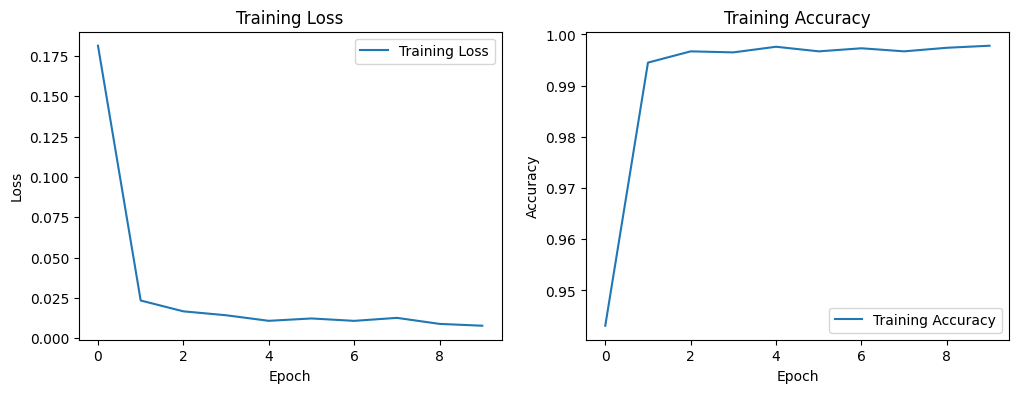

Accuracy on the test set: 98.80%


In [11]:
# Freeze all weights except the fully connected layer
for param in resnet.parameters():
    param.requires_grad = False

# Replace the fully connected layer and make it trainable
resnet.fc.weight.requires_grad = True
resnet.fc.bias.requires_grad = True

# Move the model to the device
resnet.to(device)


# Define loss optimizer
ce_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001, momentum=0.9)

# Training loop with CE loss
num_epochs = 10
losses = []
accuracies = []

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = ce_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)


# Plotting
plt.figure(figsize=(12, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluation
resnet.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {100 * accuracy:.2f}%")

As you see, the model top accuracy  is 99.78% on training set and 98.80% on test set.

# Part 3

In last part I traiend the model (feature extractor and FC) with CE and triplet loss. The model is trained with 5 epochs and SGD (lr=0.001,momentum=0.9). The results are plotted in following cell.

Files already downloaded and verified
Files already downloaded and verified


<ipython-input-12-0c7bb6cebd6c>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fc_pretrained_biases = torch.tensor(resnet.fc.bias[:2])
<ipython-input-12-0c7bb6cebd6c>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fc_pretrained_weights = torch.tensor(resnet.fc.weight[:2,:])


Epoch 1/5, Total Loss: 1.335087326678861, Accuracy: 0.8842
Epoch 2/5, Total Loss: 0.22083624838584995, Accuracy: 0.9718
Epoch 3/5, Total Loss: 0.111941713987462, Accuracy: 0.9856
Epoch 4/5, Total Loss: 0.037177176698977694, Accuracy: 0.9931
Epoch 5/5, Total Loss: 0.015947178579534493, Accuracy: 0.9963


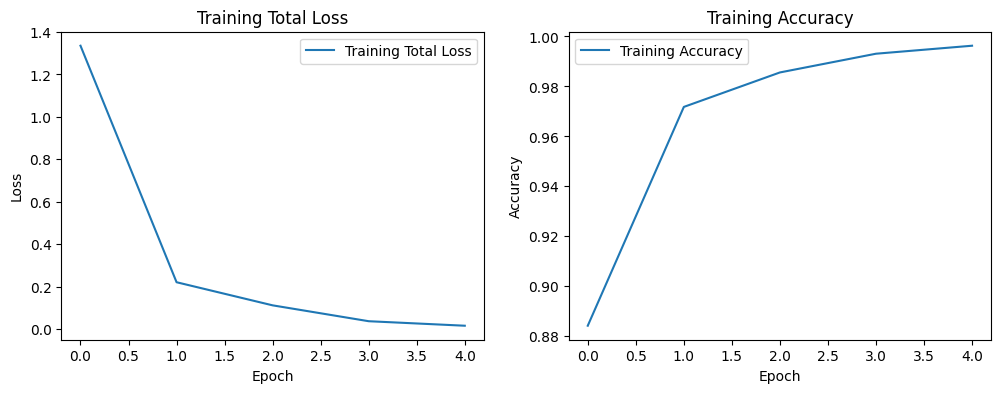

Accuracy on the test set: 98.75%


In [12]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load Cifar-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter the dataset for Automobile (class 1) and Airplane (class 0)
classes_of_interest = [0, 1]
train_indices = [i for i, label in enumerate(train_dataset.targets) if label in classes_of_interest]
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)

# Similarly, filter the test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_indices = [i for i, label in enumerate(test_dataset.targets) if label in classes_of_interest]
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load pre-trained ResNet model
resnet = models.resnet18(pretrained=True)

# save fc pretrained weights
fc_pretrained_biases = torch.tensor(resnet.fc.bias[:2])
fc_pretrained_weights = torch.tensor(resnet.fc.weight[:2,:])

# Keep the weights of the existing layers and only replace the fully connected layer
num_classes = len(classes_of_interest)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# load pretrained FC weights
resnet.fc.bias.data = fc_pretrained_biases
resnet.fc.weight.data = fc_pretrained_weights

# Move the model to the device
resnet.to(device)

# Define losses
triplet_criterion = TripletLoss(device)
cross_entropy_criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Training loop with Total loss
num_epochs = 5
losses = []
accuracies = []

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)

        trip_loss = triplet_criterion(outputs, labels)
        ce_loss = cross_entropy_criterion(outputs, labels)
        total_loss = trip_loss + ce_loss
        total_loss.backward()
        optimizer.step()

        running_loss += ce_loss.item() + trip_loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

# Plotting
plt.figure(figsize=(12, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Total Loss')
plt.title('Training Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Evaluation
resnet.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {100 * accuracy:.2f}%")

As you see, the model top accuracy is 99.63% on training set and 98.75% on test set.